In [8]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('kmeans').getOrCreate()

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import when, col, count

import numpy as np
import matplotlib.pyplot as plt


In [2]:
OOSR = spark.read.csv('OOSR.csv', inferSchema=True, header=True)

In [3]:
# Perform StringIndex conversion on classification features
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(OOSR) 
            for column in ['Age_group', 'Gender', 'Region']]
indexed_data = OOSR
for indexer in indexers:
    indexed_data = indexer.transform(indexed_data)

feature_cols = ['Age_group_index', 'Gender_index', 'Region_index']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(indexed_data)

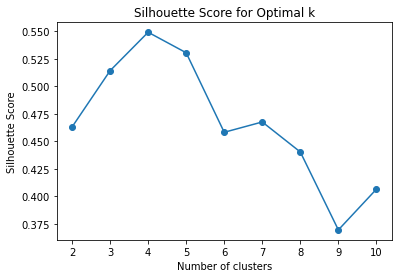

Optimal number of clusters (k): 4


In [4]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(k=k, seed=722)
    model = kmeans.fit(assembled_data)
    predictions = model.transform(assembled_data)
    
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()
    
best_k = np.argmax(silhouette_scores) + 2
print("Optimal number of clusters (k):", best_k)


In [5]:
kmeans = KMeans(k=4, seed=722)
model = kmeans.fit(assembled_data)

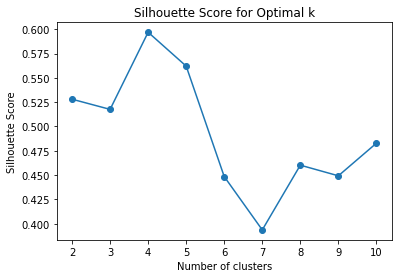

Optimal number of clusters (k): 4
+-------------------+---------------+------+------+----------+
|Countries and areas|      Age_group|Gender|Region|prediction|
+-------------------+---------------+------+------+----------+
|        Afghanistan|     Preprimary|  Male|  Asia|         0|
|        Afghanistan|     Preprimary|Female|  Asia|         0|
|        Afghanistan|        Primary|Female|  Asia|         3|
|        Afghanistan|        Primary|  Male|  Asia|         3|
|        Afghanistan|Lower_Secondary|Female|  Asia|         0|
|        Afghanistan|Lower_Secondary|  Male|  Asia|         0|
|        Afghanistan|Upper_Secondary|Female|  Asia|         3|
|        Afghanistan|Upper_Secondary|  Male|  Asia|         3|
|            Albania|     Preprimary|Female|Europe|         1|
|            Albania|     Preprimary|  Male|Europe|         1|
|            Albania|        Primary|  Male|Europe|         2|
|            Albania|        Primary|Female|Europe|         2|
|            Albania|

In [6]:
# Perform StringIndex conversion on classification features
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(OOSR) 
            for column in ['Age_group', 'Gender', 'Region']]
indexed_data = OOSR
for indexer in indexers:
    indexed_data = indexer.transform(indexed_data)

feature_cols = ['Age_group_index', 'Gender_index', 'Region_index']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(indexed_data)

# Divide the data set into a training set and a test set
train_data, test_data = assembled_data.randomSplit([0.7, 0.3], seed=722)

# Find the optimal number of clusters using the training data
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(k=k, seed=722)
    model = kmeans.fit(train_data)
    predictions = model.transform(train_data)
    
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()
    
best_k = np.argmax(silhouette_scores) + 2
print("Optimal number of clusters (k):", best_k)

# Fit the final model on the training data with the optimal number of clusters
kmeans = KMeans(k=best_k, seed=722)
model = kmeans.fit(train_data)

age_group_order = when(col("Age_group") == "Preprimary", 1).when(col("Age_group") == "Primary", 2) \
                  .when(col("Age_group") == "Lower_Secondary", 3).when(col("Age_group") == "Upper_Secondary", 4)

predictions = model.transform(assembled_data.orderBy("Countries and areas", age_group_order))
predictions.select('Countries and areas', 'Age_group', 'Gender', 'Region', 'prediction').show()

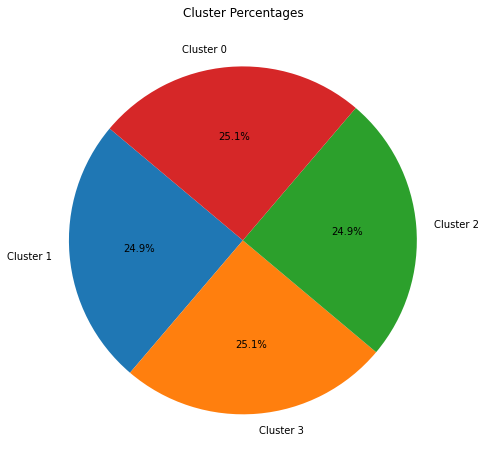

In [9]:
# Calculate the count and percentage of each cluster
cluster_counts = predictions.groupBy("prediction").agg(count("*").alias("count"))
total_count = predictions.count()
cluster_percentages = cluster_counts.withColumn("percentage", (col("count") / total_count) * 100)

# Collect data to plot
cluster_data = cluster_percentages.collect()
labels = [f'Cluster {row["prediction"]}' for row in cluster_data]
sizes = [row["percentage"] for row in cluster_data]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Cluster Percentages')
plt.show()

In [13]:
test_predictions = model.transform(test_data)

# Evaluate the final model on the test data
test_silhouette_score = round(evaluator.evaluate(test_predictions), 2) 
print("Silhouette Score on test data:", test_silhouette_score)

Silhouette Score on test data: 0.59
